In [1]:
import dask.dataframe as dd
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import boto3
import pickle
import numpy as np
from sklearn.metrics import mean_squared_error,average_precision_score
import joblib
import os
import seaborn as sns
import warnings
from sklearn.preprocessing import label_binarize
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from dateutil.relativedelta import relativedelta 
import re
from unicodedata import normalize
from shared import util
import gc
from sklearn.model_selection import ParameterSampler
from sklearn.decomposition import TruncatedSVD,NMF,KernelPCA,PCA
from sklearn.neighbors import KNeighborsClassifier,NearestNeighbors
from sklearn.cluster import KMeans 

n_iter = 35
init_points = 20

import boto3
s3 = boto3.client('s3')
s3.download_file("fury-data-apps", "marketing-utils/pzenone/utils.py","utils.py")
import sys
sys.path.append(os.path.dirname(os.path.expanduser(".")))
sys.path.append(os.path.dirname(os.path.expanduser("./utils.py")))
import utils

sys.path.append(os.path.dirname(os.path.expanduser(".")))
sys.path.append(os.path.dirname(os.path.expanduser("./defines.py")))
sys.path.append(os.path.dirname(os.path.expanduser("../defines.py")))
from defines import *

sys.path.append(os.path.dirname(os.path.expanduser("../preprocessing.py")))
from preprocessing import generate_summary,reg_data,define_Notchurn,define_churn,define_notDefined,first_ml,ml_payers,ml_sellers,mp_sellers,asset_mgm,movimientos_wallet,wallet_buyer,first_mp,prepaid,locations,app_mp
# agregar imputer de location
s3_path_in = s3_path+"Dataset_seeds/"   # Common path

In [2]:
def my_map(target,lookalike,ascending = False):
    df = pd.DataFrame([])
    df["target"] = np.array(target)
    df["lookalike"] = np.array(lookalike)
    df = df.sort_values(by = "lookalike",ascending = ascending)
    df["row_number"] = [x+1 for x in list(range(df.shape[0]))] 
    aux = df.loc[df.target == 1]
    aux["row_number_target"] = [x+1 for x in list(range(aux.shape[0]))]  
    aux["score"] = aux["row_number_target"]/aux["row_number"]
    return aux["score"].sum()/aux.shape[0]
    

In [3]:
steps = [generate_summary,ml_payers,ml_sellers,asset_mgm,wallet_buyer,mp_sellers,first_ml,first_mp,prepaid,app_mp,reg_data,locations,movimientos_wallet]
summary_cal = pd.DataFrame([])

for func in steps:
    print("Func:",func.__name__,"Amt:",summary_cal.shape[0])
    summary_cal,_ = func(None,summary_cal,"Dataset_seeds")
    
descartados = summary_cal.loc[(summary_cal.CUS_RU_SINCE_DT == fill_recency) & (summary_cal.install_app == fill_recency) & (summary_cal.AMT_MOVIMIENTOS == 0) & (summary_cal.CANT_VTAS_QR == 0)].cust
summary_cal = summary_cal.loc[~summary_cal.cust.isin(descartados.values)]

summary_cal.to_pickle("summary_applied.pkl")
utils.my_upload_file("summary_applied.pkl","s3://"+fda_path+s3_path+"Dataset_seeds"+"/summary_cal.pkl")

summary_cal = pd.DataFrame([])

for func in steps:
    print("Func:",func.__name__,"Amt:",summary_cal.shape[0])
    summary_cal,_ = func(None,summary_cal,"Dataset_resto")
    
descartados = summary_cal.loc[(summary_cal.CUS_RU_SINCE_DT == fill_recency) & (summary_cal.install_app == fill_recency) & (summary_cal.AMT_MOVIMIENTOS == 0) & (summary_cal.CANT_VTAS_QR == 0)].cust
summary_cal = summary_cal.loc[~summary_cal.cust.isin(descartados.values)]

summary_cal.to_pickle("summary_applied.pkl")
utils.my_upload_file("summary_applied.pkl","s3://"+fda_path+s3_path+"Dataset_resto"+"/summary_cal_full.pkl")

Func: generate_summary Amt: 0
Shape of users_seeds.csv: (188346, 5)
Func: ml_payers Amt: 180042
Shape of ml_payers.csv: (56898, 6)
Func: ml_sellers Amt: 180042
Shape of ml_sellers.csv: (3606, 6)
Func: asset_mgm Amt: 180042
Shape of asset_mgm.csv: (147080, 2)
Func: wallet_buyer Amt: 180042
Shape of payments_wallet.csv: (73410, 5)
Func: mp_sellers Amt: 180042
Shape of sellers_wallet.csv: (12091, 3)
Func: first_ml Amt: 180042
Shape of first_ml.csv: (188346, 6)
Func: first_mp Amt: 180042
Shape of first_buy.csv: (85104, 4)
Func: prepaid Amt: 180042
Shape of ppd.csv: (103829, 8)
Func: app_mp Amt: 180042
Shape of app_mp.csv: (87796, 2)
Func: reg_data Amt: 180042
Shape of Demo.csv: (186821, 8)
Func: locations Amt: 180042
Func: movimientos_wallet Amt: 180042
Shape of movimientos_dinero_transac.csv: (2957349, 3)
Func: generate_summary Amt: 0
Shape of users_seeds.csv: (593560, 2)
Func: ml_payers Amt: 593560
Shape of ml_payers.csv: (286577, 6)
Func: ml_sellers Amt: 593560
Shape of ml_sellers.csv: 

## downsampleo para tarbajar despues

In [14]:
summary_cal = utils.read_pickle_csv("s3://"+fda_path+s3_path+"Dataset_resto"+"/summary_cal_full.pkl")

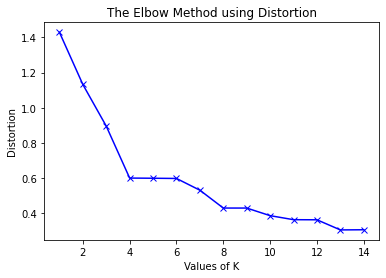

In [6]:
# Busco el codo de kmeans

from sklearn.cluster import KMeans 
from sklearn import metrics 
from scipy.spatial.distance import cdist 
import numpy as np 
import matplotlib.pyplot as plt  
from sklearn.preprocessing import StandardScaler

distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,15) 
X = StandardScaler().fit_transform(summary_cal[["CUS_RU_SINCE_DT","install_app","AMT_MOVIMIENTOS","CANT_VTAS_QR"]]) 
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k,n_jobs=-1)
    kmeanModel.fit(X)     
    
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / X.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / X.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

In [15]:
#Downsampling

kmeanModel = KMeans(n_clusters=4,n_jobs=-1)
X = StandardScaler().fit_transform(summary_cal[["CUS_RU_SINCE_DT","install_app","AMT_MOVIMIENTOS","CANT_VTAS_QR"]]) 
kmeanModel.fit(StandardScaler().fit_transform(X))     

summary_cal["cluster"] = kmeanModel.predict(X)

full,sample = train_test_split(summary_cal,test_size=0.05,stratify=summary_cal["cluster"])

sample.to_pickle("summary_applied.pkl")
utils.my_upload_file("summary_applied.pkl","s3://"+fda_path+s3_path+"Dataset_resto"+"/summary_cal.pkl")

### Me armo combinacion de features para probar que combineta es la optima

In [4]:
# Me fijo que feature hay que borrar para reducir un poco la dimensionalidad y que las combinaciones no se me disparen tanto
# train_cols_sinlocation = ['CUS_FIRST_BUY', 'CUS_FIRST_PUBLICATION',
#        'CUS_FIRST_SELL', 'CUS_RU_SINCE_DT', 'T_FRIST_VENTA',
#        'ml_sum_sales_payers', 'ml_SI_payers', 'recency_ml_payers',
#        'ml_SI_sellers','recency_ml_sellers', 'CANT_VTAS_QR',
#        'eligible', 'investing', 'pending', 'AMT_MOVIMIENTOS', 'MAX_MONEY', 'MIN_MONEY',
#        'COUNT_IN', 'TPN_sales', 'mp_sum_sales_payer',
#        'recency_mp_payer', 'FIRST_BUY', 'FIRST_HAS_DISCOUNT',
#        'install_app']

summary_cal = utils.read_pickle_csv("s3://"+fda_path+s3_path+"Dataset_seeds"+"/summary_cal.pkl") # Levanto las semillas

train_cols_sinlocation = ['TPV','ml_sum_sales_payers', 'recency_ml_payers',
       'ml_SI_sellers', 'recency_ml_sellers',
       'ml_frequency_sellers', 'disabled', 'eligible',
       'investing', 'pending', 'TPN_sales',
       'mp_sum_sales_payer', 'mp_frequency_payer',
       'FREQ_VTAS_QR', 'CUS_FIRST_BUY',
       'CUS_FIRST_PUBLICATION', 'CUS_FIRST_SELL', 'CUS_RU_SINCE_DT',
       'T_FRIST_VENTA', 'FIRST_BUY', 'FIRST_APP_BUY', 'HAS_PREPAID',
       'ppd_recency','ppd_max_money', 'ppd_first_activation', 'ACTIVO_PREPAID',
       'install_app', 'REG_CUST_INCOMES',
       'REG_CUST_BIRTHDATE', 'hot_profession',
       'educacion', 'sexo', 'locations', 'AMT_MOVIMIENTOS', 'MAX_MONEY',
        'MAX_IN', 'COUNT_IN']
        
df_study = pd.DataFrame(StandardScaler().fit_transform(summary_cal[train_cols_sinlocation]),columns = train_cols_sinlocation) 
df_corr = df_study.corr()
df_corr.to_csv("corres.csv",index=True)
df_corr

,TPV,ml_sum_sales_payers,recency_ml_payers,ml_SI_sellers,recency_ml_sellers,ml_frequency_sellers,disabled,eligible,investing,pending,...,REG_CUST_INCOMES,REG_CUST_BIRTHDATE,hot_profession,educacion,sexo,locations,AMT_MOVIMIENTOS,MAX_MONEY,MAX_IN,COUNT_IN
TPV,1.000000,0.047451,0.012995,0.009750,0.024149,0.027575,0.015439,-0.033182,0.052855,-0.001933,...,0.059889,0.029529,0.004848,0.019518,-0.012779,0.008666,0.074601,0.258619,0.247327,0.127531
ml_sum_sales_payers,0.047451,1.000000,0.311353,0.101850,0.132622,0.117067,0.017058,-0.033286,0.080821,0.000981,...,0.037467,0.018192,-0.025864,0.016259,-0.043442,-0.006750,0.070788,0.065275,0.095059,0.063380
recency_ml_payers,0.012995,0.311353,1.000000,0.027522,0.115054,0.073700,0.023705,-0.019340,0.141176,0.004420,...,0.012668,-0.018038,-0.030673,0.000680,-0.057386,-0.051077,0.109613,0.035292,0.053353,0.099317
ml_SI_sellers,0.009750,0.101850,0.027522,1.000000,0.161669,0.487326,0.009405,-0.014033,0.020982,-0.002589,...,0.002263,0.002106,-0.014737,0.004203,-0.004808,-0.007300,0.024023,0.256911,0.412400,0.042790
recency_ml_sellers,0.024149,0.132622,0.115054,0.161669,1.000000,0.475309,0.020605,-0.053830,0.084233,-0.009034,...,0.027839,0.014635,-0.029148,0.011722,-0.024969,-0.034331,0.100445,0.086361,0.135072,0.069057
ml_frequency_sellers,0.027575,0.117067,0.073700,0.487326,0.475309,1.000000,0.027543,-0.038396,0.058303,-0.010144,...,0.011177,0.008504,-0.030181,0.008007,-0.004386,-0.023079,0.067727,0.183977,0.306418,0.080608
disabled,0.015439,0.017058,0.023705,0.009405,0.020605,0.027543,1.000000,-0.071643,-0.153198,-0.036813,...,-0.025429,-0.031935,-0.009432,-0.008490,-0.005989,0.006166,0.089063,0.012255,0.024698,0.078089
eligible,-0.033182,-0.033286,-0.019340,-0.014033,-0.053830,-0.038396,-0.071643,1.000000,-0.484163,-0.116343,...,0.044457,0.014132,0.004623,0.026638,0.034896,-0.038868,-0.446783,-0.061221,-0.107140,-0.339693
investing,0.052855,0.080821,0.141176,0.020982,0.084233,0.058303,-0.153198,-0.484163,1.000000,-0.248782,...,-0.029570,0.002088,-0.014225,-0.031585,-0.053031,0.033882,0.638038,0.102749,0.170505,0.526074
pending,-0.001933,0.000981,0.004420,-0.002589,-0.009034,-0.010144,-0.036813,-0.116343,-0.248782,1.000000,...,-0.015410,-0.000612,-0.004021,-0.004989,-0.006435,0.000975,0.025816,-0.014305,-0.017266,-0.036374


In [19]:

fijas=[]
train_cols_comb = ['recency_ml_payers', 'investing', 'AMT_MOVIMIENTOS',
       'FIRST_APP_BUY', 'educacion', 'locations', 'ml_sum_sales_payers',
       'CUS_FIRST_SELL', 'T_FRIST_VENTA', 'REG_CUST_INCOMES', 'FIRST_BUY',
       'recency_ml_sellers', 'ml_SI_sellers', 'sexo',
       'mp_frequency_payer', 'TPN_sales', 'CUS_RU_SINCE_DT', 'MAX_MONEY']

train_cols = train_cols_comb + fijas

In [21]:
import itertools

combinations = []
for L in range(4, 18):  # Trunco a maximo 20 features
    print(L)
    for subset in itertools.combinations(train_cols_comb, L):
        combinations.append(list(subset))
    
# combinations = [x + fijas for x in combinations]

4
5
6
7
8
9
10
11
12
13
14
15
16
17


### Preparo dataset. Train - seeds - proof

In [3]:
others = utils.read_pickle_csv("s3://"+fda_path+s3_path+"Dataset_resto"+"/summary_cal_full.pkl")
seeds = utils.read_pickle_csv("s3://"+fda_path+s3_path+"Dataset_seeds"+"/summary_cal.pkl")
seeds = seeds.loc[seeds.TPV > 700]

# Para diferenciarlas
others["alto"] = -1
seeds["alto"] = 1

seeds,proof = train_test_split(seeds,test_size=0.6,random_state=0)
seeds,test_seeds = train_test_split(seeds,test_size=0.2,random_state=0)
others,test_others = train_test_split(others,test_size=0.2,random_state=0)

others,_ = train_test_split(others,test_size=0.6,random_state=0,stratify=others.FECHA_VENTA) # downsample por fecha que entro a visitar

cols = others.columns
summary_cal = others.append(proof[cols],ignore_index = True )
test = test_others.append(test_seeds[cols],ignore_index = True )

summary_cal.to_pickle("summary_applied.pkl")
utils.my_upload_file("summary_applied.pkl","s3://"+fda_path+s3_path+"Dataset_resto/summary_cal_train.pkl")

test.to_pickle("summary_applied.pkl")
utils.my_upload_file("summary_applied.pkl","s3://"+fda_path+s3_path+"Dataset_resto/summary_cal_test.pkl")

seeds.to_pickle("summary_applied.pkl")
utils.my_upload_file("summary_applied.pkl","s3://"+fda_path+s3_path+"Dataset_seeds/summary_cal_seeds.pkl")

seeds.shape

(43315, 56)

### Itero por columnas

In [23]:
train = utils.read_pickle_csv("s3://"+fda_path+s3_path+"Dataset_resto/summary_cal_train.pkl")
seeds = utils.read_pickle_csv("s3://"+fda_path+s3_path+"Dataset_seeds/summary_cal_seeds.pkl")

In [24]:
train_cols = ['recency_ml_payers', 'investing', 'AMT_MOVIMIENTOS',
       'FIRST_APP_BUY', 'educacion', 'locations', 'ml_sum_sales_payers',
       'CUS_FIRST_SELL', 'T_FRIST_VENTA', 'REG_CUST_INCOMES', 'FIRST_BUY',
       'recency_ml_sellers', 'ml_SI_sellers', 'sexo',
       'mp_frequency_payer', 'TPN_sales', 'CUS_RU_SINCE_DT', 'MAX_MONEY']

def knn(X_train_seeds,X_train):
    neigh = NearestNeighbors(n_jobs=-1, n_neighbors = 3500,metric = "cosine")
    neigh.fit(X_train_seeds)

    distances, _ = neigh.kneighbors(X_train)
    distances.sort(axis=1)

    y = []
        
    for i in range(1,100,10):
        local_train = train[["alto"]].copy()
        local_train["dist"] = distances[:,0:i].mean(axis = 1)
        resu = my_map(local_train["alto"],local_train["dist"],ascending = True)
        y.append(resu)
        
    for i in range(100,3500,100):
        local_train = train[["alto"]].copy()
        local_train["dist"] = distances[:,0:i].mean(axis = 1)
        resu = my_map(local_train["alto"],local_train["dist"],ascending = True)
        y.append(resu)
        
    return y

In [18]:
# for c in train_cols:
#     train_cols_ = [x for x in train_cols if(x != c)]
#     std = StandardScaler()
#     std = std.fit(seeds[train_cols_])

#     X_train_seeds = std.transform(seeds[train_cols_])
#     X_train = std.transform(train[train_cols_])

#     y = knn(X_train_seeds,X_train)
#     pd.DataFrame([{"cols_out":c,"score":max(y)}]).to_csv('scores_cols_out.csv', mode='a', header=False,index=False)
# scores = pd.read_csv("scores_cols_out.csv",header = None)
# scores.columns = ["cols","score"]

# scores.sort_values(by="score").head(18).cols.values

array(['recency_ml_payers', 'investing', 'AMT_MOVIMIENTOS',
       'FIRST_APP_BUY', 'educacion', 'locations', 'ml_sum_sales_payers',
       'CUS_FIRST_SELL', 'T_FRIST_VENTA', 'REG_CUST_INCOMES', 'FIRST_BUY',
       'recency_ml_sellers', 'ml_SI_sellers', 'sexo',
       'mp_frequency_payer', 'TPN_sales', 'CUS_RU_SINCE_DT', 'MAX_MONEY'],
      dtype=object)

In [ ]:
index = np.random.choice(len(combinations),50000,replace = False)

for i,ind in enumerate(index):
    train_cols_ = combinations[ind]
    std = StandardScaler()
    std = std.fit(seeds[train_cols_])

    X_train_seeds = std.transform(seeds[train_cols_])
    X_train = std.transform(train[train_cols_])

    y = knn(X_train_seeds,X_train)
    pd.DataFrame([{"cols":train_cols_,"score":max(y)}]).to_csv('scores.csv', mode='a', header=False,index=False)

    if(i%100 == 0):
        utils.prints3(i)

In [5]:
# from imblearn.under_sampling import ClusterCentroids

# under = ClusterCentroids(train.loc[train.alto == 1].shape[0]/(train.loc[train.alto == -1].shape[0]*0.5),n_jobs = -1,voting='soft')
# X,y = under.fit_resample(train[train_cols],train.alto)

# train = pd.DataFrame(X,columns = train_cols)
# train["alto"] = y

In [28]:
scores = pd.read_csv("scores.csv",header = None)
scores.columns = ["features","score"]
scores["features"] = scores["features"].apply(lambda x: x.strip('][').replace("'","").split(', '))
l_scores = scores.sort_values(by="score",ascending = False).features.values[0:10]


### Ya se cuales son los features mas importantes, ahora me fijo la red de dim optima

In [29]:
!pip install keras

from sklearn.manifold import LocallyLinearEmbedding
from sklearn.decomposition import PCA,FastICA
from sklearn.manifold import MDS
from sklearn.manifold import Isomap
from sklearn.manifold import TSNE
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection
from sklearn.manifold import LocallyLinearEmbedding
import keras
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.pipeline import Pipeline


You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [ ]:
all_metrics = pd.DataFrame([])

for train_cols_ in l_scores:   
    # Modelos varios
    df = pd.DataFrame([],columns = ["model","param","metric"])
    all_curves = []
    models = [FastICA,GaussianRandomProjection,TruncatedSVD]

    for model in models:
        utils.prints3("Model:",model.__name__)
        for params in range(len(train_cols_)-4,len(train_cols_),1):
            pipe = Pipeline([('std', StandardScaler()), ('red', model(n_components = params))])
            pipe = pipe.fit(seeds[train_cols_])

            X_train_seeds = pipe.transform(seeds[train_cols_])
            X_train = pipe.transform(train[train_cols_])

            y = knn(X_train_seeds,X_train)
            gc.collect()
            utils.prints3({"model":model.__name__,"param":params,"metric":max(y)})
            all_curves.append(y)
            df.append(pd.DataFrame([{"model":model.__name__,"param":params,"metric":max(y)}]))
            utils.prints3("Ready iter")

    # Autoencoders:
    scaler = StandardScaler()
    scaler = scaler.fit(seeds[train_cols_])

    X_train_seeds = scaler.transform(seeds[train_cols_])
    X_train = scaler.transform(train[train_cols_])

    utils.prints3("Model: Autoencoder")
    models = []
    for params in range(len(train_cols_)-4,len(train_cols_),1):
        m = Sequential()
        m.add(Dense(params,  activation='relu', name="bottleneck", input_shape=(X_train.shape[1],)))
        m.add(Dense(X_train.shape[1],    activation='relu'))
        m.compile(loss='mean_squared_error', optimizer = Adam())
        history = m.fit(X_train, X_train, batch_size=128, epochs=5, verbose=1)
        encoder = Model(m.input, m.get_layer('bottleneck').output)
        models.append(encoder)
        utils.prints3("autoencoder entrenado")

        X_train_seeds_ = encoder.predict(scaler.transform(seeds[train_cols_]))
        X_train_ = encoder.predict(scaler.transform(train[train_cols_]))

        y = knn(X_train_seeds_,X_train_)
        gc.collect()
        utils.prints3({"model":"Autoencoder","param":params,"metric":max(y)})
        all_curves.append(y)
        df.append(pd.DataFrame([{"model":"Autoencoder","param":params,"metric":max(y)}]))
        utils.prints3("Ready iter")
    
    df["train_cols"] = train_cols_
    all_metrics = all_metrics.append(df,ignore_index=True)

utils.prints3("Ready all")

### Ya se la combinacion optima, me fijo la cantidad optima a promediar

In [73]:
from sklearn.decomposition import PCA,FastICA
train_cols_ = ['recency_ml_payers', 'investing', 'ml_sum_sales_payers',
                 'CUS_FIRST_SELL', 'T_FRIST_VENTA', 'REG_CUST_INCOMES',
                 'ml_SI_sellers']

train_cols_ = l_scores[0]

pipe = Pipeline([('std', StandardScaler()), ('red', TruncatedSVD(n_components = 4))])
pipe = pipe.fit(seeds[train_cols_])

X_train_seeds = pipe.transform(seeds[train_cols_])
X_train = pipe.transform(train[train_cols_])

# y = knn(X_train_seeds,X_train)

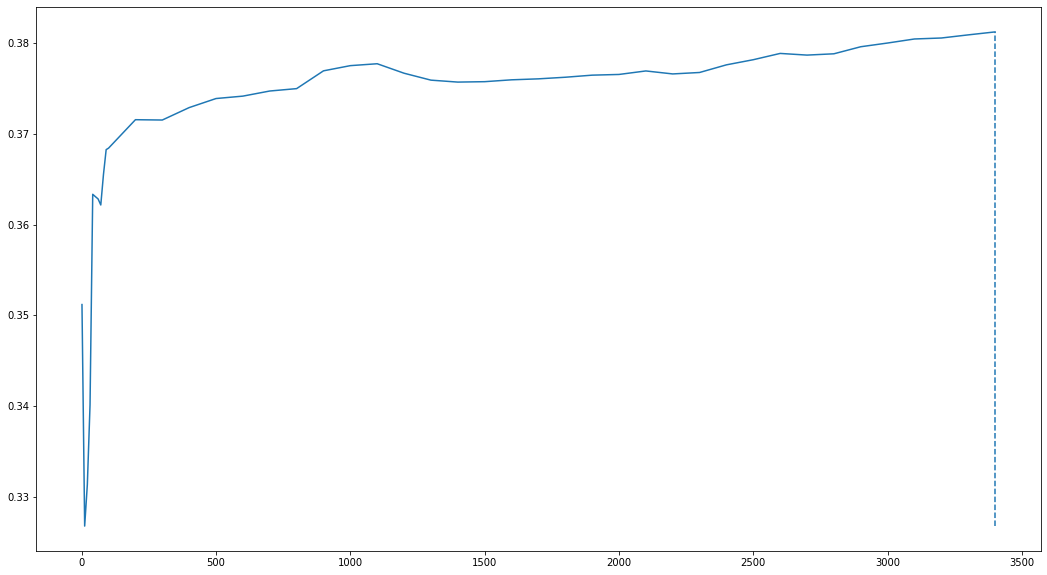

In [64]:
# Corte optimo en 100
x = list(range(1,100,10)) + list(range(100,3500,100))
max_y = np.argmax(y)
plt.figure(figsize=(18,10))
plt.plot(x,y)
plt.vlines(x=x[max_y],ymin=min(y),ymax=max(y),linestyle="dashed")

In [ ]:
## Miro que pasa en testing
def knn2(X_train_seeds,X_train,alto):
    neigh = NearestNeighbors(n_jobs=-1, n_neighbors = 8000,metric = "cosine")
    neigh.fit(X_train_seeds)

    distances, _ = neigh.kneighbors(X_train)
    distances.sort(axis=1)

    y = []
        
    for i in range(1,100,10):
        resu = my_map(alto,distances[:,0:i].mean(axis = 1),ascending = True)
        y.append(resu)
        
    for i in range(100,8000,100):
        resu = my_map(alto,distances[:,0:i].mean(axis = 1),ascending = True)
        y.append(resu)
        
    return y

test = utils.read_pickle_csv("s3://"+fda_path+s3_path+"Dataset_resto/summary_cal_test.pkl")

X_train_seeds = pipe.transform(seeds[train_cols_])
X_train = pipe.transform(test[train_cols_])

yy = knn2(X_train_seeds,X_train,test.alto.values)

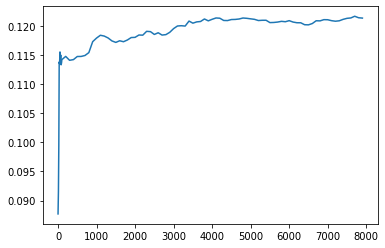

In [77]:
# Corte optimo en 100
x = list(range(1,100,10)) + list(range(100,8000,100))
# max_y = np.argmax(y)
# plt.figure(figsize=(18,10))
# plt.plot(x,y)
# plt.vlines(x=x[max_y],ymin=min(y),ymax=max(y),linestyle="dashed")

max_y = np.argmax(yy)
plt.plot(x,yy)

## Ready combinacion optima, red de dim, corte de promedio. Ahora Armo el modelo final

In [79]:
# Entreno el modelo posta
train_cols_ = ['recency_ml_payers', 'FIRST_APP_BUY', 'locations', 'ml_sum_sales_payers', 'T_FRIST_VENTA', 'recency_ml_sellers', 'ml_SI_sellers']

seeds = utils.read_pickle_csv("s3://"+fda_path+s3_path+"Dataset_seeds/summary_cal_seeds.pkl")

pipe = Pipeline([('std', StandardScaler()), ('red', TruncatedSVD(n_components = 4))])
pipe = pipe.fit(seeds[train_cols_])

neigh = NearestNeighbors(n_jobs=-1, n_neighbors = 3000,metric = "cosine")
neigh.fit(X_train_seeds)
    
with open('preprocessing.pkl', 'wb') as fout:
    pickle.dump(pipe, fout)
utils.my_upload_file("preprocessing.pkl","s3://"+fda_path+ s3_path_out + "preprocessing.pkl")

with open('KNN.pkl', 'wb') as fout:
    pickle.dump(neigh, fout)
utils.my_upload_file("KNN.pkl","s3://"+fda_path+ s3_path_out + "KNN.pkl")

## Ready modelo. Me traigo todos los datos y aplico para medir curva PR

In [5]:
from imblearn.over_sampling import SMOTE

train_cols_ = ['recency_ml_payers', 'FIRST_APP_BUY', 'locations', 'ml_sum_sales_payers', 'T_FRIST_VENTA', 'recency_ml_sellers', 'ml_SI_sellers']

train = utils.read_pickle_csv("s3://"+fda_path+s3_path+"Dataset_resto/summary_cal_train.pkl")
    
utils.my_download_file("s3://"+fda_path+ s3_path_out + "preprocessing.pkl","preprocessing.pkl")
with open("preprocessing.pkl", 'rb') as file:
    preprocessing = pickle.load(file)
    
utils.my_download_file("s3://"+fda_path+ s3_path_out + "KNN.pkl","KNN.pkl")
with open("KNN.pkl", 'rb') as file:
    KNN = pickle.load(file)
    
train.alto = train.alto.replace({-1:0})
X_train = preprocessing.transform(train[train_cols_])


distances, indices = KNN.kneighbors(X_train)

local_train = pd.DataFrame(train.alto.values,columns = ["alto"])
local_train["dist"] = distances.mean(axis = 1)

Text(0.5, 1.0, 'Curva PR')

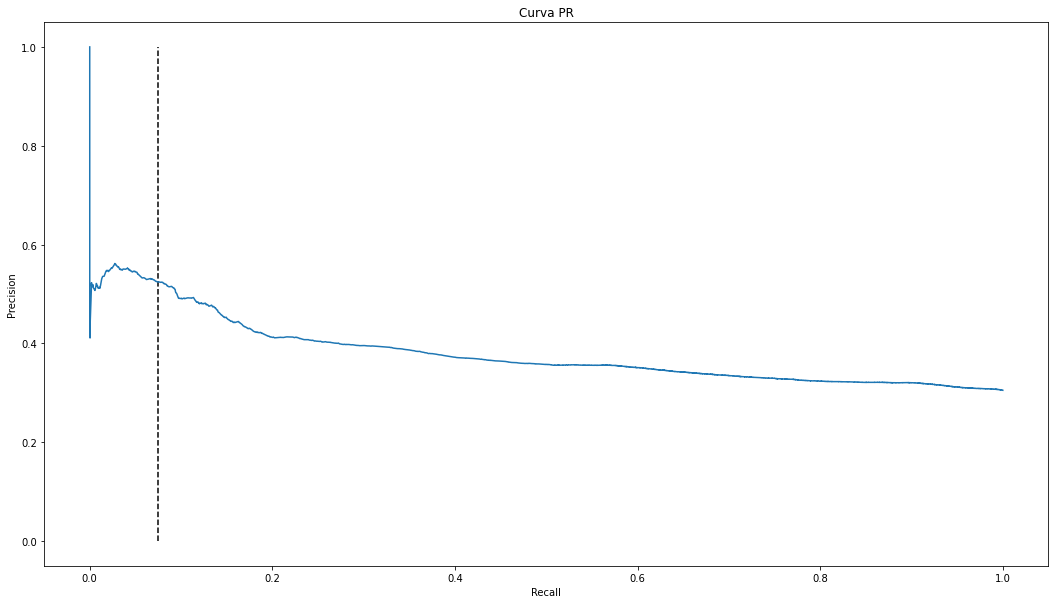

In [4]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(local_train["alto"],1-local_train["dist"])
plt.figure(figsize=(18,10))
plt.plot(recall,precision)
plt.vlines(x=0.075,ymin=0,ymax=1,linestyles="dashed",color = "black")
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Curva PR")
